In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt2
import time
import datetime
import os
import matplotlib.style
from pandas.core.common import flatten
from functools import partial, reduce
from scipy.signal import argrelextrema


In [2]:
plt.style.use('ggplot')

In [3]:
path = 'C:\\Work\Projects\\python\\flask\strategies\\igdata'

In [4]:
pairs_list = []
for filename in os.listdir(path):
    if filename.endswith('.csv'):
        pairs_list.append(filename.split('.')[0])
print(pairs_list)


['naturalgas_15Min', 'naturalgas_1H', 'naturalgas_4H', 'naturalgas_5Min', 'naturalgas_D']


In [5]:

df = {}
dd = {}

for pair in range(len(pairs_list)):
    t = str(pairs_list[pair].split('_')[1])
    df[pair] = pd.read_csv(path + '\\' + pairs_list[pair]+'.csv', header = 2)
    #df[pair].drop([4,5,6,7,8,9,10,11,12], axis=01)
    #df[pair] = df[pair].iloc[0,1,2,3,4,13]
    df[pair] = df[pair].iloc[:,[0,1,2,3,4,5,6,7,8,9,10,11,12,13]]
    df[pair].columns = ['Date', 'Bid Open', 'Bid High', 'Bid Low', 'Bid Close',\
                                'Ask Open', 'Ask High', 'Ask Low', 'Ask Close',\
                                'Open', 'High', 'Low', 'Close', 'Volume']
    df[pair]['Open'] = df[pair]['Bid Open']
    df[pair]['High'] = df[pair]['Bid High']
    df[pair]['Low'] = df[pair]['Bid Low']
    df[pair]['Close'] = df[pair]['Bid Close']
    #df[pair]['Date'] = df[pair]['Date'].str.split(' ').str[0:2]
    #df[pair]['Date'] = df[pair]['Date'].str.join(' ')
    df[pair].set_index('Date', inplace = True)
    df[pair].index = pd.to_datetime(df[pair].index, format = '%Y.%m.%d %H:%M:%S.%f')
    df[pair]['Day'] = df[pair].index.dayofweek
    dmap = {0: 'Mon', 1: 'Tue', 2: 'Wed', 3: 'Thu', 4: 'Fri', 5: 'Sat', 6: 'Sun'}
    df[pair]['Day'] = df[pair]['Day'].map(dmap)
    df[pair]['min'] = ''
    df[pair]['max'] = ''
    dd[t] = df[pair]
    
for key in dd:
    print(f'Key: {key} - rows: {len(dd[key])}')


Key: 15Min - rows: 9503
Key: 1H - rows: 5914
Key: 4H - rows: 1598
Key: 5Min - rows: 8461
Key: D - rows: 939


In [6]:
def SMA(df, period):
    df[str(period) + '_sma'] = df['Close'].rolling(period).mean()
    return df[str(period) + '_sma']

def EMA(df, period):
    df[str(period) + '_ema'] = df['Close'].ewm(span = period,adjust=False).mean()
    return  df[str(period) + '_ema']

def PriceCrossover(df, price_col, indicator_col):
    conditions  = [ (df[indicator_col].shift(1) > df[price_col].shift(1)) & (df[indicator_col] < df[price_col]),\
                    (df[indicator_col].shift(1) < df[price_col].shift(1)) & (df[indicator_col] > df[price_col])]
    choices     = ['BreakUp','BreakDown']
    df[price_col +'_'+ indicator_col + '_crossover'] = np.select(conditions, choices, default=np.nan)
    df[price_col +'_'+ indicator_col + '_crossover_price'] = np.where(df[price_col +'_'+ indicator_col + '_crossover']==\
                                                                      'nan','nan',df[price_col])
    return  df

def Trend(df):
    conditions  = [df['Close'] > df['100_sma'], df['Close'] < df['100_sma']]
    choices     = ['Up','Down']
    df['Trend'] = np.select(conditions, choices, default=np.nan)
    return  df['Trend']

def ATR(df, n):
    df = df.copy()
    df['High-Low'] = abs(df['High'] - df['Low'])
    df['High-PrevClose'] = abs(df['High'] - df['Close'].shift(1))
    df['Low-PrevClose'] = abs(df['Low'] - df['Close'].shift(1))
    df['TR'] = df[['High-Low', 'High-PrevClose', 'Low-PrevClose']].max(axis = 1, skipna = False)
    df['ATR'] = df['TR'].rolling(n).mean()
    df = df.drop(['High-Low', 'High-PrevClose', 'Low-PrevClose'], axis = 1)
    return df

def CAGR(df, source_df):
    df = df.copy()
    n = len(source_df) / (252*24)
    return round((((df['cum_res'][-1] / account_size)**(1/n)) - 1) * 100, 1)

def sharpe_ratio(df):
    df = df.copy()
    returns = df['cum_res'].pct_change()
    volatility = returns.std() * np.sqrt(252)
    return round((returns.mean() - 0.02) / volatility, 2)

def max_drawdown(df):
    df = df.copy()
    cum_returns = (1 + df['cum_res']).cumprod()
    drawdown = 1 - df['cum_res'].div(df['cum_res'].cummax())
    return round(max(drawdown.expanding().max() * 100), 2)


In [7]:
#Strategy parameters
account_size = 10000
slippage = 2
size = 1
ATR_SL = 0.5
spread = 2
plot_trades = False
pair = '5Min'

In [8]:
for res in dd:
    price = dd[res]['Close']
    #SMA(df[pair], 200).to_csv('200sma.csv')
    dd[res]['200_sma'] = SMA(dd[res], 200)
    dd[res]['100_sma'] = SMA(dd[res], 100)
    dd[res]['50_sma'] = SMA(dd[res], 50)
    dd[res]['20_sma'] = SMA(dd[res], 20)
    dd[res]['9_ema'] = EMA(dd[res], 9)
    dd[res]['Trend'] = Trend(dd[res])
    dd[res]['Close_9_ema_crossover'] = PriceCrossover(dd[res], 'Close','9_ema')['Close_9_ema_crossover']
    dd[res]['9_ema_20_sma_crossover'] = PriceCrossover(dd[res], '9_ema','20_sma')['9_ema_20_sma_crossover']
    
    dd[res].to_csv(f'NG_{res}.csv')
    
    #plt.figure(figsize = (26, 6))
    
    #plt2.title("Stock Price Chart " +  res)
    #Plot line chart
    #plt.plot(dd[res]['Close'], label='Prices',color = 'black')
    #plt.plot(dd[res]['200_sma'], label='200MA',color = 'blue', linestyle='dashed',linewidth=1.5)
    #plt.plot(dd[res]['100_sma'], label='100MA',color = 'red')
    #plt.plot(dd[res]['50_sma'], label='50MA',color = 'grey')
    #plt.plot(dd[res]['20_sma'], label='20MA',color = 'green')
    #plt.plot(dd[res]['9_ema'], label='9EMA',color = 'purple', linestyle='dashed')
    #plt.scatter(dd[res].index, np.where(dd[res]['Close_9_ema_crossover']!=np.nan, dd[res]['Close_9_ema_crossover_price'] ,np.nan),  s = 20, color = 'green')
    #plt.scatter(dd[res].index, dd[res]['Close_9_ema_crossover_price'],  s = 20, color = 'green')
    #plt.legend()
    #plt.figure()

    #Plot candlestick Chart
    
    #create figure
    #plt2.figure(figsize = (26, 6))

    #plt2.title("Stock Price Chart " +  res)
        
    #define width of candlestick elements
    #width = .4
    #width2 = .1

    #define up and down prices
    #up = dd[res][dd[res].Close >= dd[res].Open]
    #down = dd[res][dd[res].Close < dd[res].Open]

    #define colors to use
    #col1 = 'green'
    #col2 = 'red'

    #plot up prices
    #plt2.bar(up.index,up.Close - up.Open, width, bottom = up.Open,color=col1)
    #plt2.bar(up.index,up.High - up.Close, width2, bottom = up.Close,color=col1)
    #plt2.bar(up.index,up.Low - up.Open, width2, bottom = up.Open,color=col1)

    #plot down prices
    #plt2.bar(down.index,down.Close - down.Open, width, bottom=down.Open,color=col2)
    #plt2.bar(down.index,down.High - down.Open, width2, bottom=down.Open,color=col2)
    #plt2.bar(down.index,down.Low - down.Close, width2, bottom=down.Close,color=col2)

    #plot moving averages
    #plt2.plot(dd[res]['200_sma'], label='200MA',color = 'blue', linestyle='dashed',linewidth=1.5)
    #plt2.plot(dd[res]['100_sma'], label='100MA',color = 'red')
    #plt2.plot(dd[res]['50_sma'], label='50MA',color = 'grey')
    #plt2.plot(dd[res]['20_sma'], label='20MA',color = 'green')
    #plt2.plot(dd[res]['9_ema'], label='9EMA',color = 'purple', linestyle='dashed')

    #rotate x-axis tick labels
    #plt2.xticks(rotation=45, ha='right')

    #display candlestick chart
    #plt2.show()

In [9]:
def trade_plot(df, trade, exit_price, exit_date):
    plt.figure(figsize = (25, 8))
    plt.title(trade['signal'] + ' - With result: ' + str(round(trade['result'], 2)))
    plt.plot(df['Close'][(trade['date_of_trade'] - datetime.timedelta(days = 1000)): (trade['date_of_trade'] + datetime.timedelta(days = 30))], color = 'blue')
    plt.axhline(trade['TP'], color = 'green', ls = ':')
    plt.axhline(trade['SL'], color = 'red', ls = ':')
    plt.scatter(df.index, df['min'], color = 'red', s = 100)
    plt.scatter(df.index, df['max'], color = 'green', s = 100)
    plt.scatter(trade['date_of_trade'], trade['entry_price'], color = 'yellow', s = 200)
    plt.scatter(exit_date, exit_price, color = 'orange', s = 200)

    plt.show()

In [10]:
open_trade = {}
trade = {}
long_take_profit = {}
short_take_profit = {}
long_stop_loss = {}
short_stop_loss = {}
long_entry_price = {}
short_entry_price = {}
support = {}
resist = {}

# Open trade when candle close above or below 9ema, 20sma & 50sma. 200SMA defines the trend. Close when on 9ema 20sma crossover

In [11]:


open_trade[pair] = []
trade[pair] = {}
long_take_profit[pair] = []
short_take_profit[pair] = []
long_stop_loss[pair] = []
short_stop_loss[pair] = []
long_entry_price[pair] = []
short_entry_price[pair] = []

support[pair] = []
resist[pair] = []
stop_loss_margin = 10
max_stop_loss_distance = 100
balance = 10000
dd[pair]['buy'] = np.nan
dd[pair]['sell'] = np.nan
dd[pair]['exit'] = np.nan
dd[pair]['sl'] = np.nan
dd[pair]['tp'] = np.nan
print([pair])
pd.options.mode.chained_assignment = None 

for i in range(50, len(dd[pair])):

    size = 1
    #size = int(100 * float(size)/float(balance))
    #print(str(size))
    #print('size', size)
    
    buy_stop_loss = round(min(dd[pair]['50_sma'][i],dd[pair]['20_sma'][i],dd[pair]['9_ema'][i]) - stop_loss_margin,2)
    buy_stop_loss_distance = dd[pair]['Close'][i-1] - buy_stop_loss
    sell_stop_loss = round(max(dd[pair]['50_sma'][i],dd[pair]['20_sma'][i],dd[pair]['9_ema'][i]) + stop_loss_margin,2)
    sell_stop_loss_distance = sell_stop_loss - dd[pair]['Close'][i-1]
    
    if(buy_stop_loss_distance > max_stop_loss_distance):
        buy_stop_loss = dd[pair]['Close'][i-1] - max_stop_loss_distance
    
    if(sell_stop_loss_distance > max_stop_loss_distance):
        sell_stop_loss = dd[pair]['Close'][i-1] + max_stop_loss_distance
        
    #Buy
    
    if((dd[pair]['Trend'][i] == 'Up' and \
      (dd[pair]['Close'][i] > dd[pair]['20_sma'][i] and \
       dd[pair]['Close'][i] > dd[pair]['9_ema'][i]  and \
       dd[pair]['Close'][i] > dd[pair]['50_sma'][i])  and \
       
      (dd[pair]['Close'][i-1] < dd[pair]['20_sma'][i-1] or \
       dd[pair]['Close'][i-1] < dd[pair]['9_ema'][i-1]  or \
       dd[pair]['Close'][i-1] < dd[pair]['50_sma'][i-1]))  and \
       
       len(open_trade[pair]) == 0):
            print('New Long trade at price:', round(dd[pair]['Close'][i], 4), ' On day:', dd[pair].index[i])
            print('With stop loss at ', buy_stop_loss)
            dd[pair]['buy'][i]=round(dd[pair]['Close'][i], 4)
            dd[pair]['sl'][i]=buy_stop_loss
            
            trade[pair][i] = {'ID': i,
                              'date_of_trade': dd[pair].index[i],
                              'day_of_trade': dd[pair]['Day'][i],
                              'entry_price': dd[pair]['Close'][i],
                              'signal': 'Buy',
                              'result': 0,
                              'TP': np.nan,
                              'SL': buy_stop_loss}
            open_trade[pair].append(i)
            long_take_profit[pair].append(trade[pair][i]['TP'])
            long_stop_loss[pair].append(trade[pair][i]['SL'])
            long_entry_price[pair].append(trade[pair][i]['entry_price'])
            continue

    #Sell
       
    if((dd[pair]['Trend'][i] == 'Down' and \
      (dd[pair]['Close'][i] < dd[pair]['20_sma'][i] and \
       dd[pair]['Close'][i] < dd[pair]['9_ema'][i]  and \
       dd[pair]['Close'][i] < dd[pair]['50_sma'][i])  and \
       
      (dd[pair]['Close'][i-1] > dd[pair]['20_sma'][i-1] or \
       dd[pair]['Close'][i-1] > dd[pair]['9_ema'][i-1]  or \
       dd[pair]['Close'][i-1] > dd[pair]['50_sma'][i-1]))  and \
    
       len(open_trade[pair]) == 0):
            print('New Short trade at price:', round(dd[pair]['Close'][i], 4), ' On day:', dd[pair].index[i])
            print('With stop loss at ', sell_stop_loss)
            dd[pair]['sell'][i]=round(dd[pair]['Close'][i], 4)
            dd[pair]['sl'][i]=sell_stop_loss
            trade[pair][i] = {'ID': i,
                              'date_of_trade': dd[pair].index[i],
                              'day_of_trade': dd[pair]['Day'][i],
                              'entry_price': dd[pair]['Close'][i],
                              'signal': 'Sell',
                              'result': 0,
                              'TP': np.nan,
                              'SL': sell_stop_loss}
            open_trade[pair].append(i)
            long_take_profit[pair].append(trade[pair][i]['TP'])
            long_stop_loss[pair].append(trade[pair][i]['SL'])
            long_entry_price[pair].append(trade[pair][i]['entry_price'])
            continue

    #Exit trades---------------------------------------------------------------------------

    #Buy loss
    for j in open_trade[pair]:
        if trade[pair][j].get('result', {}) == 0 and trade[pair][j].get('signal', {}) == 'Buy':
            #print(f'Checking Low: {str(dd[pair]['Low'][i-1])} against SL:{str(trade[pair][j]['SL'])}')
            if(dd[pair]['Low'][i-1] <= trade[pair][j]['SL']):
                print('Stop loss hit')
                print('Checking Low:')
                print(dd[pair]['Low'][i-1])
                print('Against SL')
                print(trade[pair][j]['SL'])
                trade[pair][j].update({'result' : (trade[pair][j]['SL'] - (trade[pair][j]['entry_price'] + spread)) * size})
                dd[pair]['exit'][i]=round(trade[pair][j]['SL'], 4)
                print('Long loss at price:', round(trade[pair][j]['SL'], 4),
                     'On day:', dd[pair].index[i],
                     'Reason:','Stopped out',
                     'With loss:', round(trade[pair][j]['result'], 4), '\n')
                open_trade[pair].remove(j)
                balance+=trade[pair][j]['result']
            #plot trade
            if plot_trades == True:
                trade_plot(dd[pair][i - 1000: i + 30], trade[pair][j], dd[pair]["Close"][i], dd[pair].index[i])
                
    #Buy profit
    for j in open_trade[pair]:
        if trade[pair][j].get('result', {}) == 0 and trade[pair][j].get('signal', {}) == 'Buy':
            if(dd[pair]['9_ema_20_sma_crossover'][i-1] == 'BreakDown' or \
               dd[pair]['Close'][i] > (dd[pair]['Close'][i] - dd[pair]['9_ema'][i]) > 100):
                print('9EMA-20MA cross')
                trade[pair][j].update({'result' : (dd[pair]['Close'][i] - trade[pair][j]['entry_price'] - spread) * size})
                dd[pair]['exit'][i]=dd[pair]['Close'][i]
                print(j,
                     'Long profit/loss at price:', round(dd[pair]['Close'][i], 4),
                     'On day:', dd[pair].index[i],
                     'With profit/loss:', round(trade[pair][j]['result'], 4), '\n')
                open_trade[pair].remove(j)
                balance+=trade[pair][j]['result']
            else:
                trade[pair][j].update({'SL' : buy_stop_loss})
                dd[pair]['sl'][i] = buy_stop_loss
                #print(trade[pair])
                #print('moved SL:', trade[pair][j]['SL'])

            #plot trade
            if plot_trades == True:
                trade_plot(dd[pair][i - 1000: i + 30], trade[pair][j], dd[pair]["Close"][i], dd[pair].index[i])

    
    
    #Sell Loss
    for j in open_trade[pair]:
        if trade[pair][j].get('result', {}) == 0 and trade[pair][j].get('signal', {}) == 'Sell':
            #print(f'Checking High: {dd[pair]['High'][i-1]} against SL:{trade[pair][j]['SL']}')
            if(dd[pair]['High'][i-1] >= trade[pair][j]['SL']):
                print('Stop loss hit')
                print('Checking High:')
                print(dd[pair]['High'][i-1])
                print('Against SL')
                print(trade[pair][j]['SL'])
            
                trade[pair][j].update({'result' : ((trade[pair][j]['entry_price'] - spread) - trade[pair][j]['SL'] ) * size})
                dd[pair]['exit'][i]=round(trade[pair][j]['SL'], 4)
                print('Short loss at price:', round(trade[pair][j]['SL'], 4),
                     'On day:', dd[pair].index[i],
                     'Reason:','Stopped out',
                     'With loss:', round(trade[pair][j]['result'], 4), '\n')
                open_trade[pair].remove(j)
                balance+=trade[pair][j]['result']
            #plot trade
            if plot_trades == True:
                    trade_plot(dd[pair][i - 1000: i + 30], trade[pair][j], dd[pair]["Close"][i], dd[pair].index[i])


    #Sell profit
    for j in open_trade[pair]:
        if trade[pair][j].get('result', {}) == 0 and trade[pair][j].get('signal', {}) == 'Sell':
            if(dd[pair]['9_ema_20_sma_crossover'][i-1] == 'BreakUp'  or \
               dd[pair]['Close'][i] < (dd[pair]['9_ema'][i] - dd[pair]['Close'][i]) > 100):
                print('9EMA-20MA cross')
                trade[pair][j].update({'result' : (trade[pair][j]['entry_price'] - (dd[pair]['Close'][i] - spread) * size)})
                dd[pair]['exit'][i]=round(dd[pair]['Close'][i], 4)
                print('Short profit/loss at price:', round(dd[pair]['Close'][i], 4),
                     'On day:', dd[pair].index[i],
                     'With profit/loss:', round(trade[pair][j]['result'], 4), '\n')
                open_trade[pair].remove(j)
                balance+=trade[pair][j]['result']
            else:
                trade[pair][j].update({'SL' : sell_stop_loss})
                dd[pair]['sl'][i] = sell_stop_loss
                #print(trade[pair])
                #print('moved SL:', trade[pair][j]['SL'])
            #plot trade
            if plot_trades == True:
                    trade_plot(dd[pair][i - 1000: i + 30], trade[pair][j], dd[pair]["Close"][i], dd[pair].index[i])

                    

['5Min']
New Long trade at price: 3432.0  On day: 2023-01-16 07:20:00
With stop loss at  3396.06
9EMA-20MA cross
100 Long profit/loss at price: 3448.0 On day: 2023-01-16 09:35:00 With profit/loss: 14.0 

New Long trade at price: 3437.0  On day: 2023-01-16 12:05:00
With stop loss at  3405.05
Stop loss hit
Checking Low:
3397.0
Against SL
3414.6
Long loss at price: 3414.6 On day: 2023-01-16 13:05:00 Reason: Stopped out With loss: -24.4 

New Short trade at price: 3415.0  On day: 2023-01-16 13:25:00
With stop loss at  3436.5
Stop loss hit
Checking High:
3453.0
Against SL
3437.2
Short loss at price: 3437.2 On day: 2023-01-16 13:40:00 Reason: Stopped out With loss: -24.2 

New Short trade at price: 3417.0  On day: 2023-01-16 14:30:00
With stop loss at  3451.09
9EMA-20MA cross
Short profit/loss at price: 3431.0 On day: 2023-01-16 16:05:00 With profit/loss: -12.0 

New Short trade at price: 3427.0  On day: 2023-01-16 17:05:00
With stop loss at  3439.63
Stop loss hit
Checking High:
3441.0
Again

With stop loss at  3119.55
Stop loss hit
Checking High:
3116.0
Against SL
3114.6
Short loss at price: 3114.6 On day: 2023-01-20 10:50:00 Reason: Stopped out With loss: -20.6 

New Long trade at price: 3105.0  On day: 2023-01-20 10:55:00
With stop loss at  3091.14
Stop loss hit
Checking Low:
3095.0
Against SL
3103.0
Long loss at price: 3103.0 On day: 2023-01-20 12:20:00 Reason: Stopped out With loss: -4.0 

New Long trade at price: 3128.0  On day: 2023-01-20 12:30:00
With stop loss at  3104.14
9EMA-20MA cross
1236 Long profit/loss at price: 3134.0 On day: 2023-01-20 12:50:00 With profit/loss: 4.0 

New Long trade at price: 3126.0  On day: 2023-01-20 13:40:00
With stop loss at  3105.34
9EMA-20MA cross
1250 Long profit/loss at price: 3165.0 On day: 2023-01-20 15:30:00 With profit/loss: 37.0 

New Long trade at price: 3187.0  On day: 2023-01-20 15:50:00
With stop loss at  3142.72
9EMA-20MA cross
1276 Long profit/loss at price: 3173.0 On day: 2023-01-20 17:20:00 With profit/loss: -16.0 

Ne

9EMA-20MA cross
Short profit/loss at price: 2879.0 On day: 2023-01-26 00:05:00 With profit/loss: 71.0 

New Short trade at price: 2874.0  On day: 2023-01-26 01:10:00
With stop loss at  2891.44
9EMA-20MA cross
Short profit/loss at price: 2814.0 On day: 2023-01-26 03:45:00 With profit/loss: 62.0 

New Short trade at price: 2810.0  On day: 2023-01-26 04:45:00
With stop loss at  2841.02
Stop loss hit
Checking High:
2822.0
Against SL
2820.7
Short loss at price: 2820.7 On day: 2023-01-26 06:05:00 Reason: Stopped out With loss: -12.7 

New Short trade at price: 2805.0  On day: 2023-01-26 06:15:00
With stop loss at  2819.44
Stop loss hit
Checking High:
2822.0
Against SL
2819.44
Short loss at price: 2819.44 On day: 2023-01-26 06:20:00 Reason: Stopped out With loss: -16.44 

New Short trade at price: 2795.0  On day: 2023-01-26 06:25:00
With stop loss at  2818.2
Stop loss hit
Checking High:
2818.0
Against SL
2813.5
Short loss at price: 2813.5 On day: 2023-01-26 07:50:00 Reason: Stopped out With l

Stop loss hit
Checking Low:
2499.0
Against SL
2502.31
Long loss at price: 2502.31 On day: 2023-02-02 10:00:00 Reason: Stopped out With loss: -21.69 

New Short trade at price: 2505.0  On day: 2023-02-02 10:35:00
With stop loss at  2525.9
9EMA-20MA cross
Short profit/loss at price: 2510.0 On day: 2023-02-02 11:15:00 With profit/loss: -3.0 

New Short trade at price: 2500.0  On day: 2023-02-02 11:20:00
With stop loss at  2522.14
Stop loss hit
Checking High:
2521.0
Against SL
2519.36
Short loss at price: 2519.36 On day: 2023-02-02 12:40:00 Reason: Stopped out With loss: -21.36 

New Long trade at price: 2530.0  On day: 2023-02-02 13:00:00
With stop loss at  2499.86
Stop loss hit
Checking Low:
2503.0
Against SL
2504.1
Long loss at price: 2504.1 On day: 2023-02-02 13:55:00 Reason: Stopped out With loss: -27.9 

New Long trade at price: 2538.0  On day: 2023-02-02 14:15:00
With stop loss at  2507.72
9EMA-20MA cross
3741 Long profit/loss at price: 2550.0 On day: 2023-02-02 14:30:00 With profit

9EMA-20MA cross
Short profit/loss at price: 2482.0 On day: 2023-02-10 06:40:00 With profit/loss: 8.0 

New Long trade at price: 2484.0  On day: 2023-02-10 08:20:00
With stop loss at  2460.78
9EMA-20MA cross
5326 Long profit/loss at price: 2495.0 On day: 2023-02-10 09:55:00 With profit/loss: 9.0 

New Short trade at price: 2470.0  On day: 2023-02-10 11:25:00
With stop loss at  2502.14
9EMA-20MA cross
Short profit/loss at price: 2479.0 On day: 2023-02-10 12:35:00 With profit/loss: -7.0 

New Short trade at price: 2467.0  On day: 2023-02-10 12:40:00
With stop loss at  2496.6
Stop loss hit
Checking High:
2496.0
Against SL
2491.72
Short loss at price: 2491.72 On day: 2023-02-10 13:20:00 Reason: Stopped out With loss: -26.72 

New Short trade at price: 2469.0  On day: 2023-02-10 13:40:00
With stop loss at  2488.34
Stop loss hit
Checking High:
2503.0
Against SL
2487.63
Short loss at price: 2487.63 On day: 2023-02-10 14:05:00 Reason: Stopped out With loss: -20.63 

New Long trade at price: 248

9EMA-20MA cross
Short profit/loss at price: 2436.0 On day: 2023-02-17 09:15:00 With profit/loss: 39.0 

New Short trade at price: 2429.0  On day: 2023-02-17 10:25:00
With stop loss at  2444.17
9EMA-20MA cross
Short profit/loss at price: 2411.0 On day: 2023-02-17 12:25:00 With profit/loss: 20.0 

New Short trade at price: 2403.0  On day: 2023-02-17 12:45:00
With stop loss at  2431.2
Stop loss hit
Checking High:
2442.0
Against SL
2432.46
Short loss at price: 2432.46 On day: 2023-02-17 13:15:00 Reason: Stopped out With loss: -31.46 

New Short trade at price: 2418.0  On day: 2023-02-17 13:45:00
With stop loss at  2433.22
Stop loss hit
Checking High:
2436.0
Against SL
2434.58
Short loss at price: 2434.58 On day: 2023-02-17 13:55:00 Reason: Stopped out With loss: -18.58 

New Short trade at price: 2326.0  On day: 2023-02-17 15:50:00
With stop loss at  2398.98
9EMA-20MA cross
Short profit/loss at price: 2334.0 On day: 2023-02-17 17:00:00 With profit/loss: -6.0 

New Short trade at price: 232

In [12]:
 print(len(open_trade[pair]))

1


In [13]:
dd

{'15Min':                      Bid Open  Bid High  Bid Low  Bid Close  Ask Open  \
 Date                                                                    
 2022-10-02 23:00:00    6841.0    6873.0   6781.0     6795.0    6850.0   
 2022-10-02 23:15:00    6796.0    6804.0   6778.0     6787.0    6799.0   
 2022-10-02 23:30:00    6792.0    6797.0   6778.0     6786.0    6801.0   
 2022-10-02 23:45:00    6788.0    6803.0   6784.0     6799.0    6794.0   
 2022-10-03 00:00:00    6798.0    6799.0   6789.0     6790.0    6804.0   
 ...                       ...       ...      ...        ...       ...   
 2023-02-27 18:00:00    2710.0    2710.0   2687.0     2696.0    2713.0   
 2023-02-27 18:15:00    2697.0    2700.0   2688.0     2696.0    2700.0   
 2023-02-27 18:30:00    2697.0    2710.0   2680.0     2686.0    2700.0   
 2023-02-27 18:45:00    2687.0    2708.0   2687.0     2708.0    2690.0   
 2023-02-27 19:00:00    2709.0    2719.0   2699.0     2710.0    2712.0   
 
                      Ask H

In [14]:
dd[pair].drop(['min','max','Bid Open','Bid High','Bid Low','Bid Close','Ask Open','Ask High','Ask Low','Ask Close'], inplace=True, axis=1)
print('columns dropped')
dd[pair].to_csv(f'NG_{pair}_results.csv')
print('csv saved')

columns dropped
csv saved


In [15]:
pairs_results = {}
profits = {}
losses = {}
be = {}

In [16]:
trade[pair]

{100: {'ID': 100,
  'date_of_trade': Timestamp('2023-01-16 07:20:00'),
  'day_of_trade': 'Mon',
  'entry_price': 3432.0,
  'signal': 'Buy',
  'result': 14.0,
  'TP': nan,
  'SL': 3423.8},
 157: {'ID': 157,
  'date_of_trade': Timestamp('2023-01-16 12:05:00'),
  'day_of_trade': 'Mon',
  'entry_price': 3437.0,
  'signal': 'Buy',
  'result': -24.40000000000009,
  'TP': nan,
  'SL': 3414.6},
 173: {'ID': 173,
  'date_of_trade': Timestamp('2023-01-16 13:25:00'),
  'day_of_trade': 'Mon',
  'entry_price': 3415.0,
  'signal': 'Sell',
  'result': -24.199999999999818,
  'TP': nan,
  'SL': 3437.2},
 186: {'ID': 186,
  'date_of_trade': Timestamp('2023-01-16 14:30:00'),
  'day_of_trade': 'Mon',
  'entry_price': 3417.0,
  'signal': 'Sell',
  'result': -12.0,
  'TP': nan,
  'SL': 3439.12},
 217: {'ID': 217,
  'date_of_trade': Timestamp('2023-01-16 17:05:00'),
  'day_of_trade': 'Mon',
  'entry_price': 3427.0,
  'signal': 'Sell',
  'result': -15.980000000000018,
  'TP': nan,
  'SL': 3440.98},
 228: {'ID

In [17]:
    
profits[pair] = []
losses[pair] = []
be[pair] = []

pairs_results[pair] = pd.DataFrame.from_dict({(i, j): trade[pair][j] for j in trade[pair].keys()}, orient = 'index')
#pairs_results[pair] = pairs_results[pair].drop(['signal', 'ID', 'TP', 'SL'], axis = 1)
pairs_results[pair].set_index('date_of_trade', inplace = True)
pairs_results[pair]['cum_res'] = pairs_results[pair]['result'].cumsum() + account_size

for t in trade[pair]:
    profits[pair].append(trade[pair][t]['result']) if trade[pair][t]['result'] > 0.1 else ''
    losses[pair].append(trade[pair][t]['result']) if trade[pair][t]['result'] < -0.1 else ''
    be[pair].append(trade[pair][t]['result']) if -0.1 <= trade[pair][t]['result'] <= 0.1 else ''


No handles with labels found to put in legend.


Text(0.5, 1.0, 'Returns of each pair')

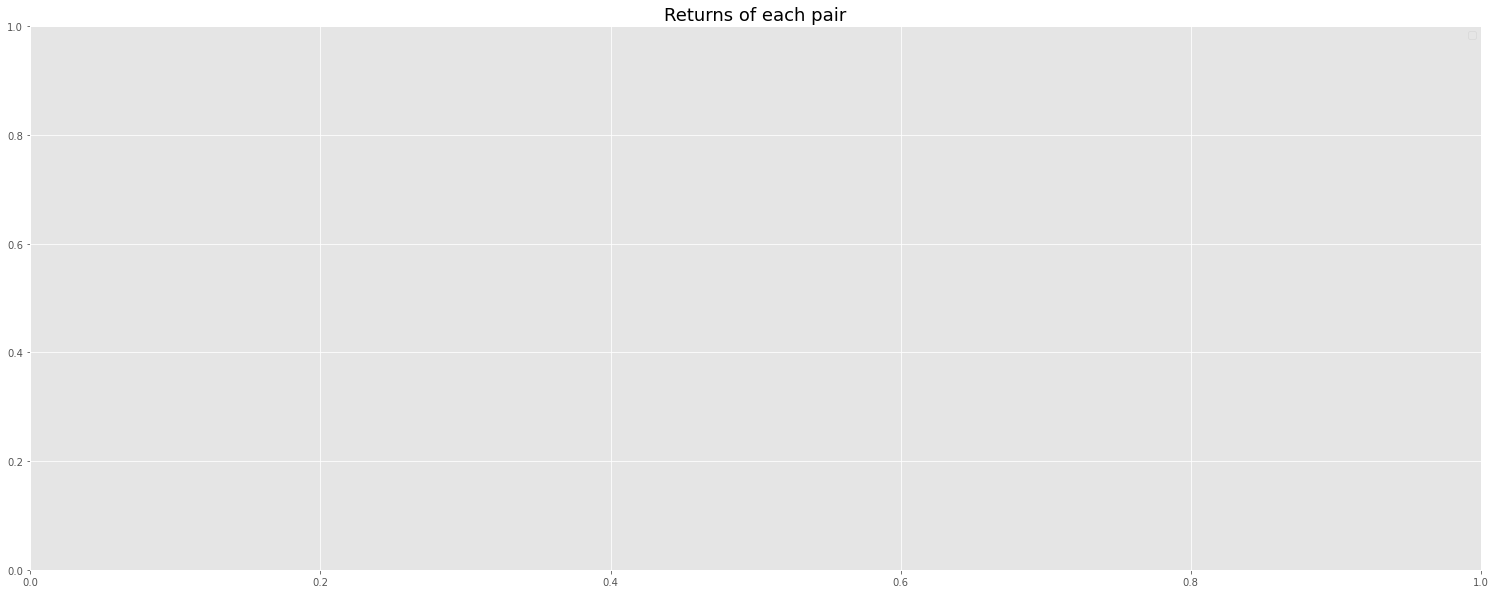

In [18]:
my_reduce = partial(pd.merge, on = 'date_of_trade', how = 'outer')
strategy_results = reduce(my_reduce, pairs_results.values())
strategy_results = strategy_results.sort_index()
strategy_results['final_res'] = strategy_results.filter(like = 'result', axis = 1).sum(axis = 1)
strategy_results['cum_res'] = strategy_results['final_res'].cumsum() + account_size

profits_keys = list(profits.keys())
profits_values = [profits[x] for x in profits_keys]
str_profits = list(flatten(profits_values))

losses_keys = list(losses.keys())
losses_values = [losses[x] for x in losses_keys]
str_losses = list(flatten(losses_values))

be_keys = list(be.keys())
be_values = [be[x] for x in be_keys]
str_be = list(flatten(be_values))

plt.figure(figsize = (26, 10))
#for pair in range(len(pairs_list)):
#    plt.plot(pairs_results[pair]['cum_res'], label = pairs_list[pair])
plt.legend()
plt.title('Returns of each pair', fontsize = 18)

In [19]:

#Strategy performance
print('***** STRATEGY PERFORMANCE *****')
print('--------------------------------')
print('CAGR:', CAGR(strategy_results, df[0]), '%')
print('Sharpe ratio:', sharpe_ratio(strategy_results))
print('Maximum drawdown', max_drawdown(strategy_results), '% \n')
print('Number of trades:', len(str_profits + str_losses + str_be))
print('Number of profits:', len(str_profits))
print('Number of losses:', len(str_losses))
print('Number of breakevens:', len(str_be), '\n')
print('Winning percentage', (round(len(str_profits) / (len(str_profits) + len(str_losses)) * 100, 2)), '%')
print('ROI:', round(strategy_results['cum_res'][-1]) - account_size)
print('--------------------------------')
#print('Average profitable trade:', round(sum(str_profits) / len(str_profits), 2))
#print('Average lossing trade:', round(sum(str_losses) / len(str_losses), 2))
#print('Max profitable trade:', round(max(str_profits), 2))
#print('Max lossing trade:', round(min(str_losses), 2))

***** STRATEGY PERFORMANCE *****
--------------------------------
CAGR: -6.4 %
Sharpe ratio: -0.39
Maximum drawdown 10.06 % 

Number of trades: 283
Number of profits: 91
Number of losses: 187
Number of breakevens: 5 

Winning percentage 32.73 %
ROI: -983
--------------------------------


Text(0.5, 1.0, 'return of strategy')

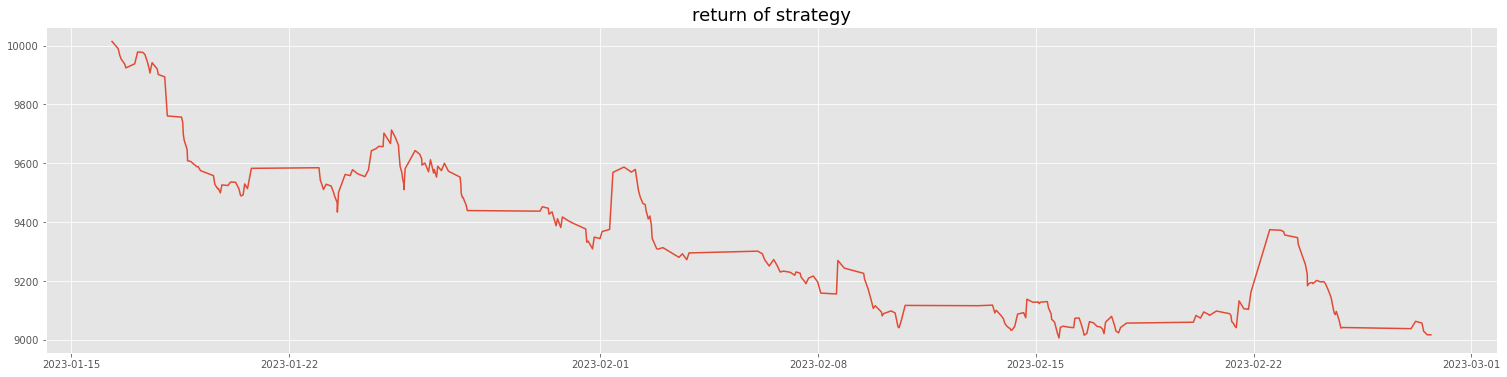

In [20]:

plt.figure(figsize = (26, 6))
plt.plot(strategy_results['cum_res'])
plt.title('return of strategy', fontsize = 18)


In [21]:

#performance for each pair
for pair in range(len(pairs_list)):
    print(pairs_list[pair], '- PERFORMANCE')
    print('--------------------------------')
    #print('Number of trades:', len(profits[pair] + losses[pair] + be[pair]))
    #print('Number of profits:', len(profits[pair]))
    #print('Number of losses:', len(losses[pair]))
    #print('Number of breakevens:', len(be[pair]), '\n')
    #print('Winning percentage', (round(len(profits[pair]) / (len(profits[pair]) + len(losses[pair])) * 100, 2)), '%')
    #print('ROI:', round(pairs_results[pair]['cum_res'][-1] - account_size, 2))
    #print('--------------------------------')
    #print('Average profitable trade:', round(sum(profits[pair]) / len(profits[pair]), 2))
    #print('Average lossing trade:', round(sum(losses[pair]) / len(losses[pair]), 2))
    #print('Max profitable trade:', round(max(profits[pair]), 2))
    #print('Max lossing trade:', round(min(losses[pair]), 2))
    #print('xxxxxxxxxxxxxxxxxxxxxxxxxxxxxx \n')

    trades_per_day = pairs_results[pair].groupby('day_of_trade').count()['result']
    day_return = pairs_results[pair].groupby('day_of_trade').sum()['result']
    day_return_positive = day_return > 0
    positive_results = pairs_results[pair]['result'] > 0

    print('Number of trades per day \n', trades_per_day)

    fig, axes = plt.subplots(4, 1, figsize = (26, 26))
    fig.tight_layout(pad = 4)

    axes[0].plot(pairs_results[pair]['cum_res'], color = 'dodgerblue')
    axes[0].set_title(pairs_list[pair], fontsize = 14)
    axes[0].set_xlabel('Days')
    axes[0].set_ylabel('Return')

    axes[1].bar(day_return.keys(), height = day_return, color = day_return_positive.map({True: 'limegreen', False: 'coral'}))
    axes[1].set_title('Returns per day', fontsize = 14)
    axes[1].set_xlabel('Days')
    axes[1].set_ylabel('Return')

    axes[2].hist(pairs_results[pair]['result'], bins = 500, color = 'purple')
    axes[2].set_title('Distribution of results', fontsize = 14)
    axes[2].set_xlabel('Size of returns')
    axes[2].set_ylabel('Number of returns')

    axes[3].plot(df[pair]['Close'], color = 'black', alpha = 0.5)
    axes[3].scatter(pairs_results[pair].index, pairs_results[pair]['entry_price'], s = 70, color = positive_results.map({True: 'green', False: 'red'}))
    axes[3].set_title('Entries', fontsize = 14)
    axes[3].set_xlabel('Date')
    axes[3].set_ylabel('price')

    plt.show()


naturalgas_15Min - PERFORMANCE
--------------------------------


KeyError: 0